Testing different ways to interact with the GLS-based dataset and generate visualiations: 

In [25]:
import pandas as pd
import os
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import random
from sklearn.preprocessing import normalize

In [26]:
path_data = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/data/GLS_TnSeq/'

In [27]:
colors_sns = sns.color_palette('colorblind')
colors_sns

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [28]:
def correlation_tile_plot(df_lfc, list_rvid_x, list_rvid_y, fig_size, cols, list_subset=[]):
    
    fig, axs = plt.subplots(len(list_rvid_x), len(list_rvid_y), figsize=fig_size)
    for i in range(len(list_rvid_x)):
        for j in range(len(list_rvid_y)):
            x_rvid = list_rvid_x[i]
            y_rvid = list_rvid_y[j] 

            x = df_lfc[df_lfc.Rv_ID==x_rvid].values[0][1:]
            y = df_lfc[df_lfc.Rv_ID==y_rvid].values[0][1:]

            axs[i,j].scatter(x, y, s = 10)
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
            if i == 0:
                axs[i,j].set_title(list_rvid_y[j], fontsize = 16)
            
            if j == 0:
                axs[i,j].set_ylabel(list_rvid_x[i], fontsize = 16)
            
            if list_rvid_x == list_rvid_y:
                if x_rvid in list_subset or y_rvid in list_subset:
                    axs[i,j].set_facecolor('xkcd:lightblue')
                if x_rvid in list_subset and y_rvid in list_subset:
                    axs[i,j].set_facecolor(cols[-2])
                if i==j:
                    axs[i,j].set_facecolor(cols[-3])

## [Exercise 1]: Generate the equivalent of SI_Data-1 from the Nat. Genet. paper: 

Load Bonferroni-corrected p-values: 

In [292]:
fn_p = 'GLS_p_AJ.npy'
fn_p_path = os.path.join(path_data, fn_p)
fn_genes = 'genes_AJ.txt'
fn_genes_path = os.path.join(path_data, fn_genes)

genes = pd.read_csv( fn_genes_path, header=None, squeeze=True)
GLS_p = pd.DataFrame( np.load(fn_p_path), columns=genes, index=genes)


In [293]:
# Compute and save weights for ClusterONE
stacked_p = GLS_p.stack()
stacked_p = stacked_p[stacked_p.index.get_level_values(0) < stacked_p.index.get_level_values(1)]
# Bonferroni-corrected p-values: 
fdr = pd.Series(fdrcorrection(stacked_p)[1], index=stacked_p.index)

Query fdr:

In [294]:
th = 0.001
fdr_th = fdr[fdr.values<=th].copy()

In [309]:
rvid = 'Rv0001'
[val for val in fdr_th.index.tolist() if val[0]==rvid or val[1]==rvid]

[('Rv0001', 'Rv0062'),
 ('Rv0001', 'Rv0283'),
 ('Rv0001', 'Rv0415'),
 ('Rv0001', 'Rv0537c'),
 ('Rv0001', 'Rv2247'),
 ('Rv0001', 'Rv2981c'),
 ('Rv0001', 'Rv3806c')]

[WARNING]: This is probably not the right way to do it: for a given RvID_x, shows as pairs genes with RvID_y > RvID_x

How do I fix that? 

In [298]:
rvid = 'Rv2939'
rvid_pair = [ind for ind in fdr_th.index if ind[0]==rvid or ind[1]==rvid]
fdr_th[rvid_pair].values.tolist()

[2.9797748434376774e-09,
 3.168079404341736e-42,
 7.681287046375145e-39,
 3.1659612695985673e-51,
 2.7825064693700116e-59,
 9.644770196476841e-52,
 5.475539015958585e-41,
 6.230989335233127e-58,
 4.689717673912365e-56]

In [299]:
list_lead_gene = []
list_partner_gene = []
list_p_fdr = []
# rvid = 'Rv2940c'
for rvid in genes.values.tolist():
    rvid_pair = [ind for ind in fdr_th.index if ind[0]==rvid or ind[1]==rvid]
    # how do I fetch the p-value for the interaction?
    p_fdr = fdr_th[rvid_pair].values.tolist()
    rvid_pair_sort = [(rv[0], rv[1]) if rv[0]==rvid else (rv[1], rv[0]) for rv in rvid_pair ]

    #lead_gene = [ rvid_pair_sort[i][0] if i==0 else '' for i in range(len(rvid_pair_sort))]
    lead_gene = [ rvid_pair_sort[i][0] for i in range(len(rvid_pair_sort))]
    partner_gene = [rvid[1] for rvid in rvid_pair_sort]

    list_lead_gene+=lead_gene
    list_partner_gene+=partner_gene
    list_p_fdr+=p_fdr

In [300]:
df_interact = pd.DataFrame()
df_interact['lead_gene'] = list_lead_gene
df_interact['partner_gene'] = list_partner_gene
df_interact['p_value_FDR'] = list_p_fdr


Adding more columns to this data: 

In [301]:
fn_out = 'test_SI_data_1_fdr.001.xlsx'
fn_out_path = os.path.join(path_data, fn_out)
df_interact.to_excel(fn_out_path, index=False)

## [Exercise 2]: Generate the equivalent of SI_Data-2 from the Nat. Genet. paper: 

In [106]:
cols = ['Cluster', 'Density', 'Size', 'Members']
list_d = [0.2, 0.5, 0.9]
df_cone_all = pd.DataFrame()
for d in list_d:
    fn = f'modules_d_{d}.csv'
    df_cone = pd.read_csv(os.path.join(path_data, fn))[cols]
    df_cone
    print(d, df_cone.shape)
    df_cone_all = pd.concat([df_cone_all, df_cone], axis=0)
df_cone_all.reset_index(inplace = True, drop=True)
df_cone_all['Cluster'] = range(1, df_cone_all.shape[0]+1)

0.2 (164, 4)
0.5 (850, 4)
0.9 (328, 4)


In [108]:
df_cone_all.drop_duplicates(subset='Members', inplace=True)

#### [PENDING]: You need to remove duplicate Clusters (different d-values)

Write to file: 

In [109]:
fn_out = 'test_SI_data_2_clustOne.xlsx'
fn_out_path = os.path.join(path_data, fn_out)
df_cone_all.to_excel(fn_out_path, index=False)

## [Exercise 3]: Given a query gene, return dataframe with genes in its cluster(s)

In [30]:
fn_up_func = '../data/tests/uniprot-proteome_UP000001584.xlsx'
df_up_func = pd.read_excel(fn_up_func)
re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df_up_func['Gene names']]
df_up_func['Rv_ID'] = list_rvids
df_up_func.sort_values(by = 'Rv_ID', inplace=True)
df_up_func['annot_int'] = [int(annot.split()[0]) for annot in df_up_func.Annotation]
cols = ['Rv_ID', 'Gene names', 'Protein names', 'Annotation', 'Function [CC]']
df_up_func = df_up_func[cols]
df_up_func.reset_index(inplace = True, drop=True)
df_up_func.head(3)

/home/ajinich/miniconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Rv_ID,Gene names,Protein names,Annotation,Function [CC]
0,Rv0001,dnaA Rv0001 MTV029.01,Chromosomal replication initiator protein DnaA,4 out of 5,FUNCTION: Plays an important role in the initi...
1,Rv0002,dnaN Rv0002 MTCY10H4.0 MTV029.02,Beta sliding clamp (Beta clamp) (Sliding clamp...,4 out of 5,FUNCTION: Confers DNA tethering and processivi...
2,Rv0003,recF Rv0003 MTCY10H4.01,DNA replication and repair protein RecF,2 out of 5,FUNCTION: The RecF protein is involved in DNA ...


In [22]:
query = 'Rv3502c'


In [153]:
path_out = os.path.join(path_data, 'Rv_ID_clusters')


for query in df_up_func.Rv_ID.tolist():

    fn_out = query+'_clusters.xlsx'
    fn_out_path = os.path.join(path_out, fn_out)
    df_query = df_cone_all[df_cone_all.Members.str.contains(query)].copy()
    
    with pd.ExcelWriter(fn_out_path) as writer:  

        for index, row in df_query.iterrows():
            df_temp = pd.DataFrame()
            list_members = row.Members.split()
            list_cluster = [row.Cluster]*len(list_members)
            df_temp['Cluster'] = list_cluster
            df_temp['Rv_ID'] = list_members
            # Add UniProt annotation info:
            df_temp_func = df_temp.merge(df_up_func, how = 'left', on = 'Rv_ID').sort_values(by = 'Annotation', ascending=False)
            df_temp_func.reset_index(inplace=True, drop=True)
            df_temp_func.to_excel(writer, sheet_name='cluster_'+str(row.Cluster), index=False)


## [Exercise 4:] generate pairwise scatterplots for query genes and its nearest neighbors:

#### Load and normalize the l2fc data: 

In [29]:
fn_lfc_basis = '../data/standardized_data/result_logfc_matrix_2021_10_22_BASIS.csv'
df_lfc_basis = pd.read_csv(fn_lfc_basis)
df_lfc_basis.dropna(axis=0, inplace=True)

cols_data = df_lfc_basis.columns[1:]
X = df_lfc_basis[cols_data].values
X_norm = normalize(X, norm='l2', axis=0)

df_lfc_basis_norm = df_lfc_basis.copy()
df_lfc_basis_norm[cols_data] = X_norm
df_lfc_basis_norm.shape

(3971, 126)

Random sets of genes: 

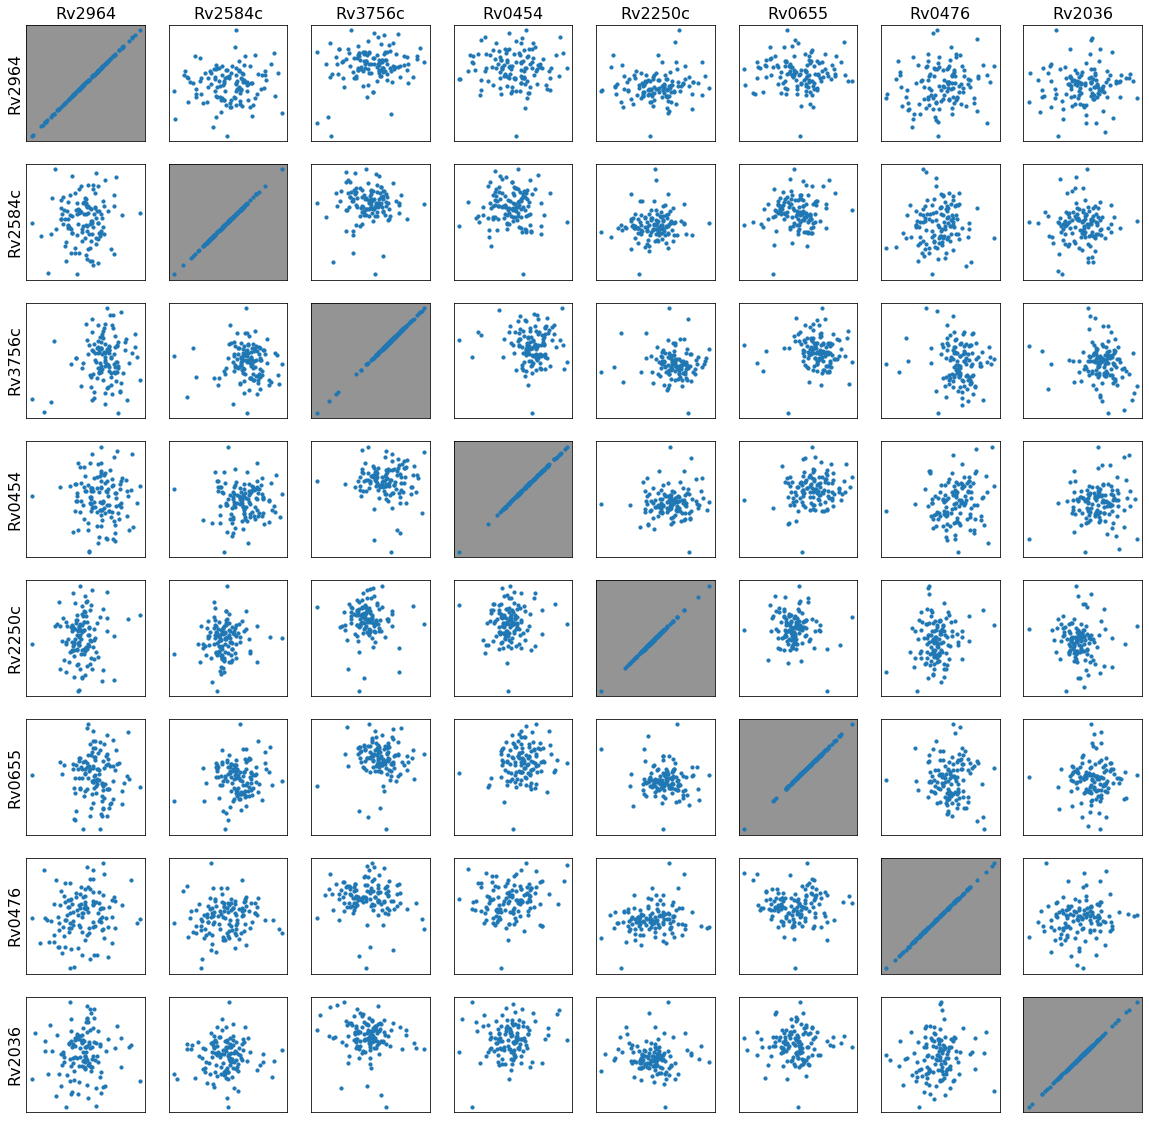

In [19]:
num_random = 8
list_rvid = df_lfc_basis_norm.sample(num_random).Rv_ID.tolist()
correlation_tile_plot(df_lfc_basis_norm, list_rvid, list_rvid, (20,20), colors_sns)

### Who do the PDIM genes cluster with:
- bpoC (Rv0554)
- mas (Rv2940c)
- Rv2808


In [13]:
rvid_pdim = ['Rv'+str(i) for i in range(2928, 2943)] + ['Rv2945c', 'Rv2946c']
ind = [i for i in range(len(rvid_pdim)) if rvid_pdim[i]=='Rv2940'][0]
rvid_pdim[ind] = 'Rv2940c'
rvid_test = ['Rv0554', 'Rv2940c', 'Rv2808']

rvid_pdim_filt = [rv for rv in rvid_pdim if rv not in ['Rv2936','Rv2937','Rv2938', 'Rv2942', 'Rv2945c', 'Rv2946c']]

In [14]:
list_subset = ['Rv2936', 'Rv2937', 'Rv2938', 'Rv2942', 'Rv2945c', 'Rv2946c']

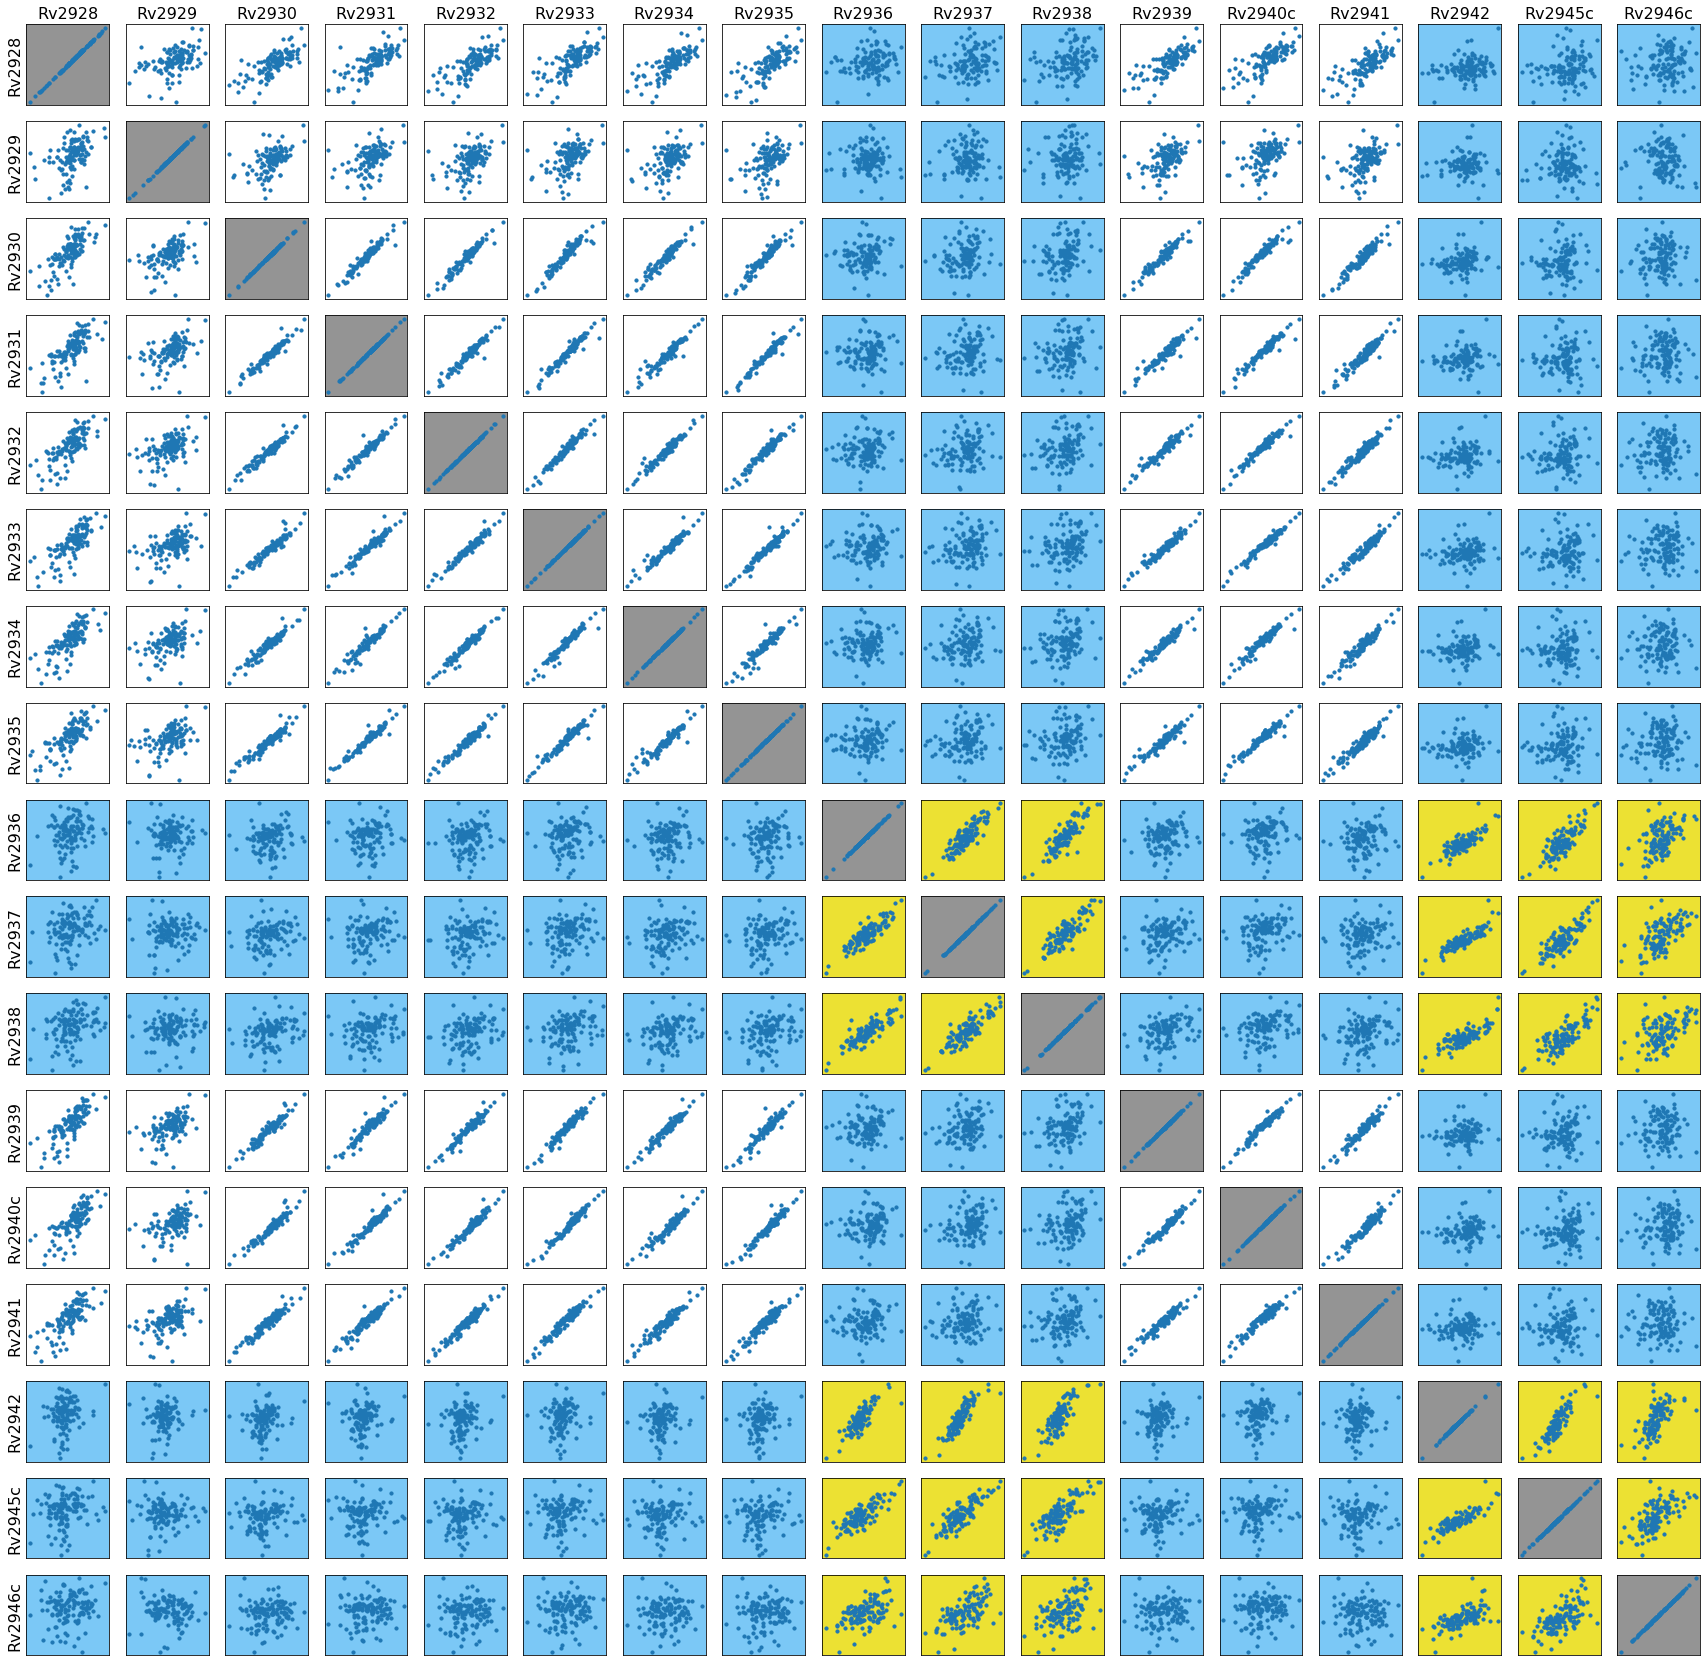

In [23]:
correlation_tile_plot(df_lfc_basis_norm, rvid_pdim, rvid_pdim, (30,30), colors_sns, list_subset)

In [24]:
size_y = int((len(rvid_pdim_filt)/3)*8)

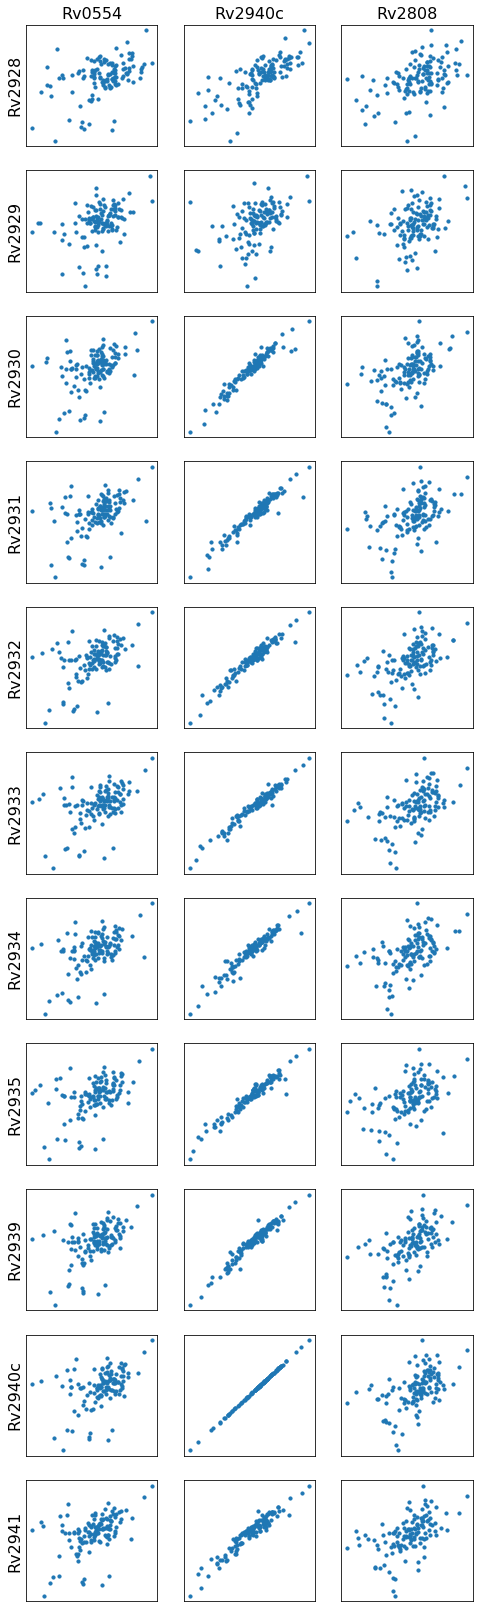

In [37]:
correlation_tile_plot(df_lfc_basis_norm, rvid_pdim_filt, rvid_test, (8,size_y), colors_sns)

#### Compare against 3 random genes: 

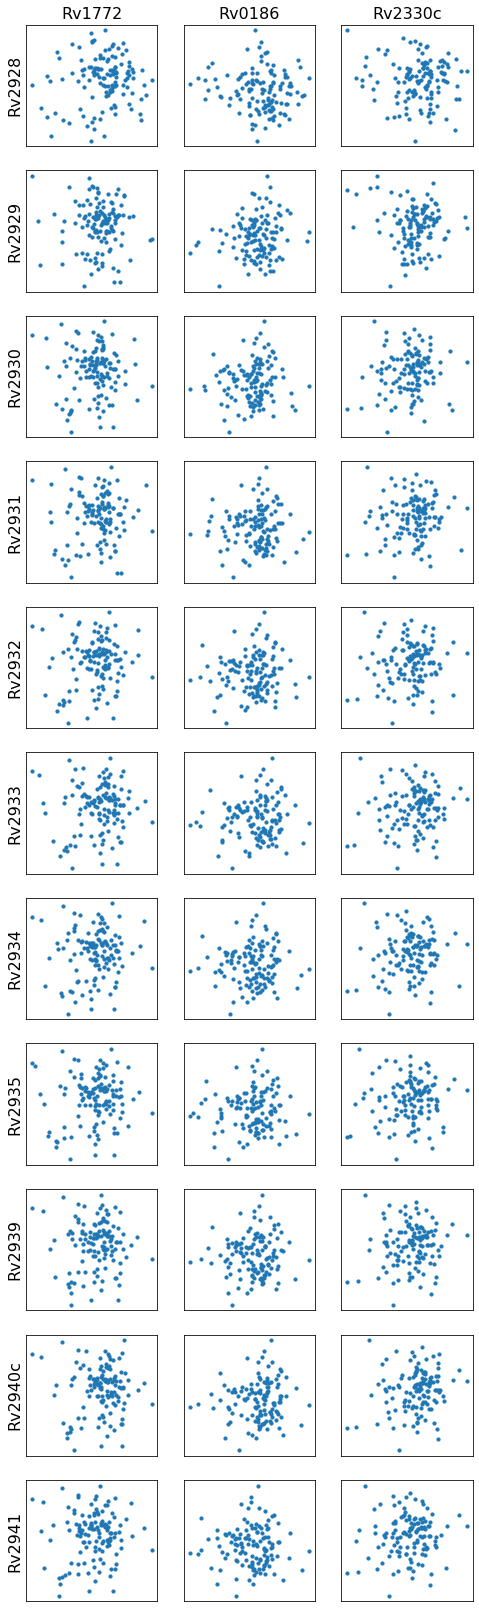

In [38]:
rvid_rand = df_lfc_basis_norm.Rv_ID.sample(3).tolist()
correlation_tile_plot(df_lfc_basis_norm, rvid_pdim_filt, rvid_rand, (8,size_y), colors_sns)

## Pairwise correlations for genes with substrates of similar molecular structure:

In [39]:
fn = '../data/tests/df_clus_ys.csv'
df_y = pd.read_csv(fn)

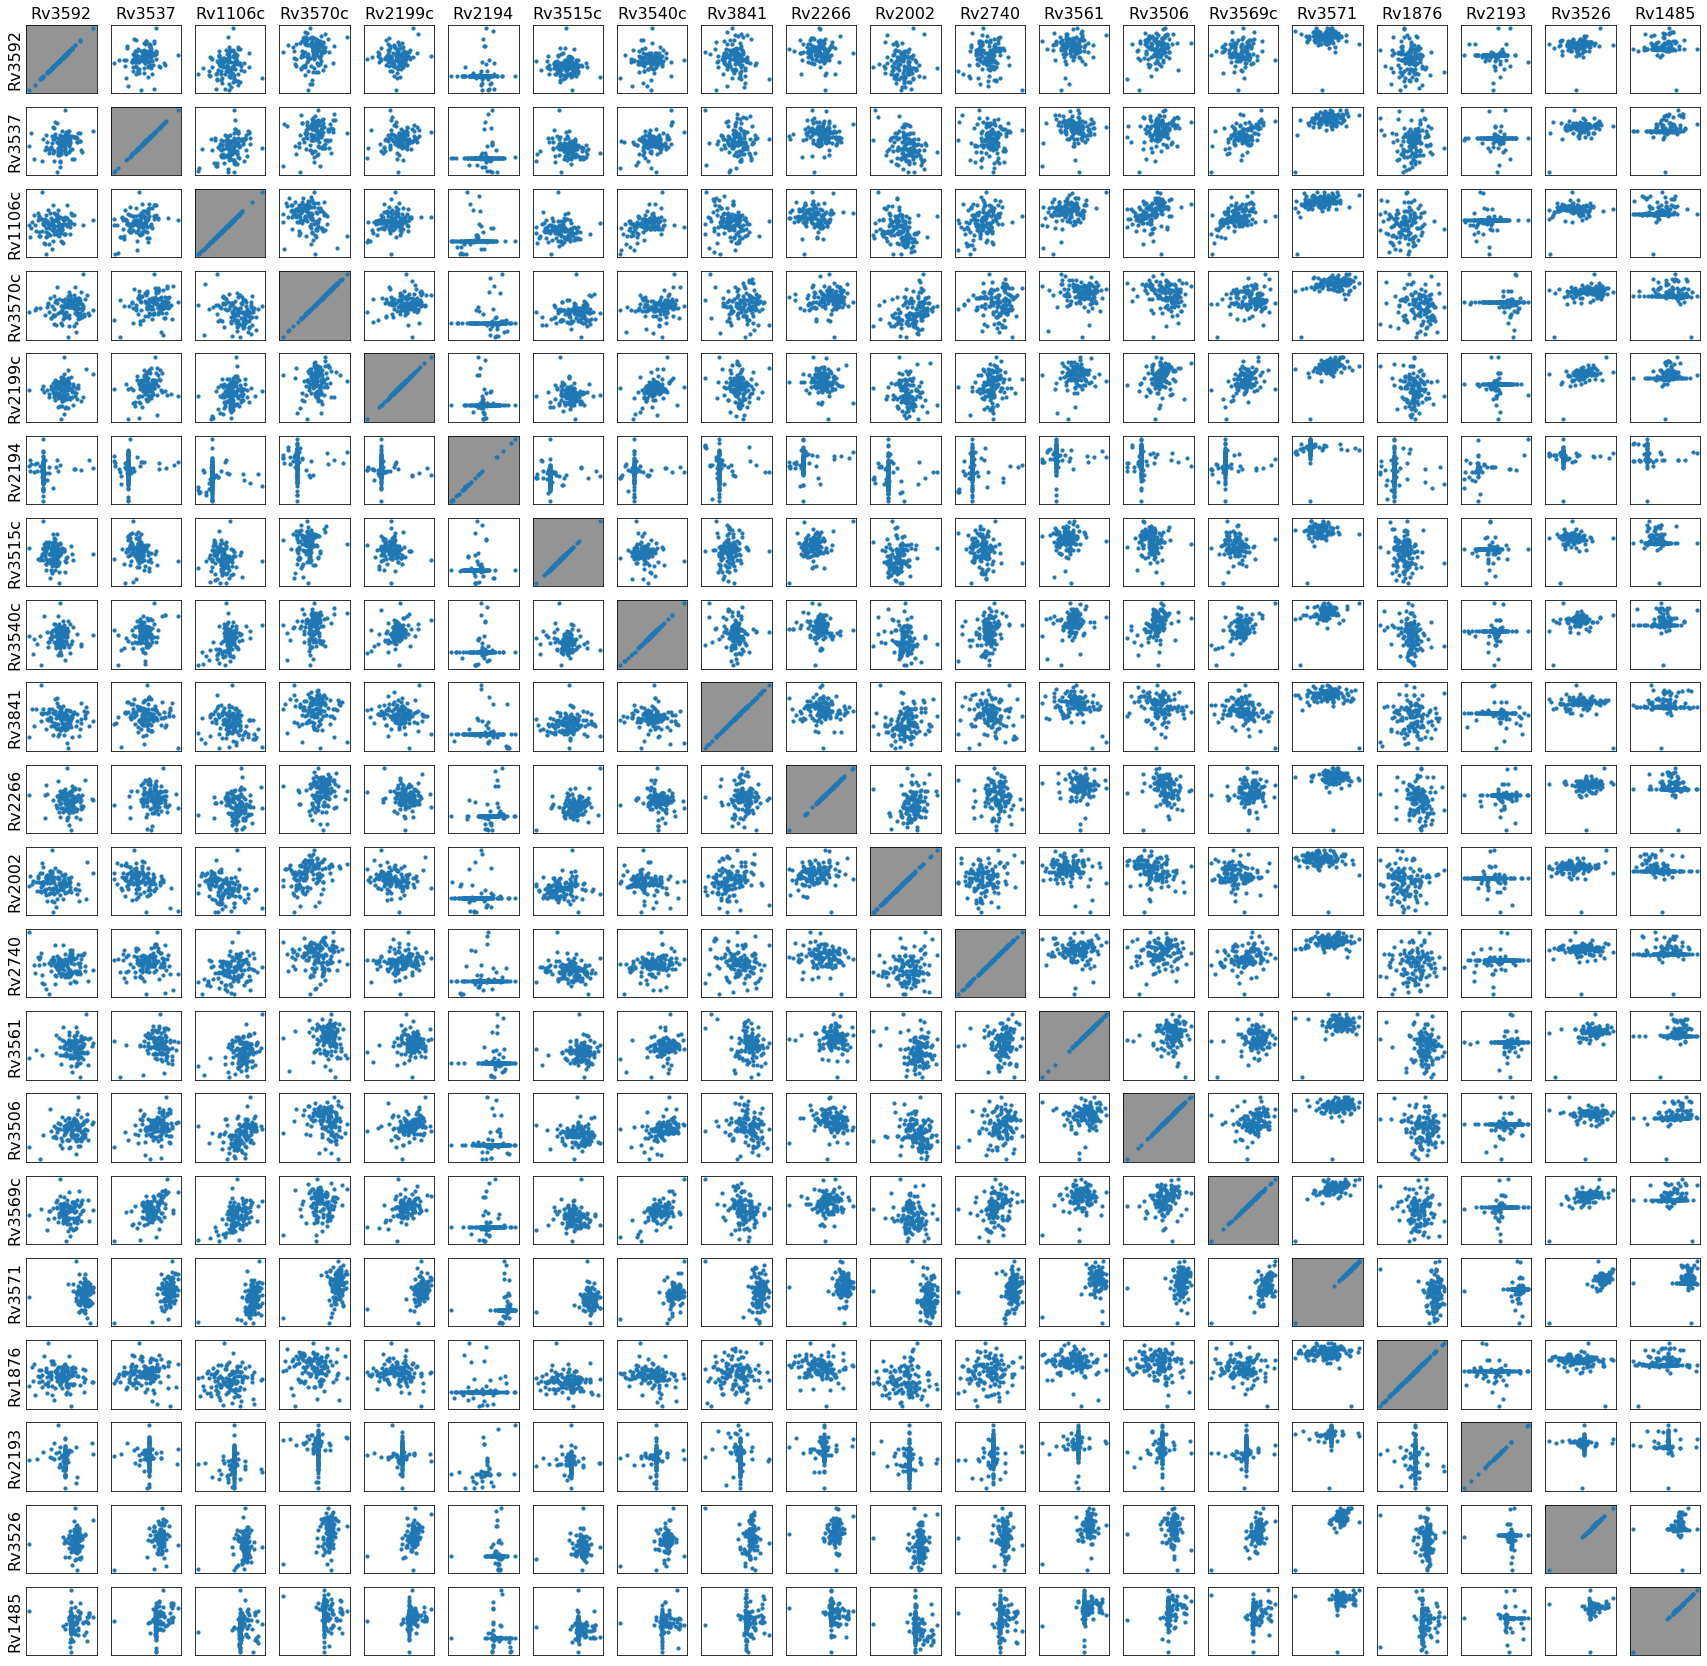

In [48]:
num_clus = 1
num_rvids = 20
list_rvid = df_y[df_y['cluster_'+str(num_clus)]==1].Rv_ID.tolist()
list_rvid_sample = random.sample(list_rvid, num_rvids)

correlation_tile_plot(df_lfc_basis_norm, list_rvid_sample, list_rvid_sample, (30,30), colors_sns)

## Maybe the most valuable thing is the pair-wise data: 

In [31]:
fn = 'test_SI_data_1_fdr.001.xlsx'
fn_path = os.path.join(path_data, fn)
df_interact = pd.read_excel(fn_path)
df_interact.head()

,lead_gene,partner_gene,p_value_FDR
0,Rv0001,Rv0062,1.835717e-04
1,Rv0001,Rv0283,4.422754e-09
2,Rv0001,Rv0415,6.268663e-09
3,Rv0001,Rv0537c,3.550883e-04
4,Rv0001,Rv2247,4.833695e-07


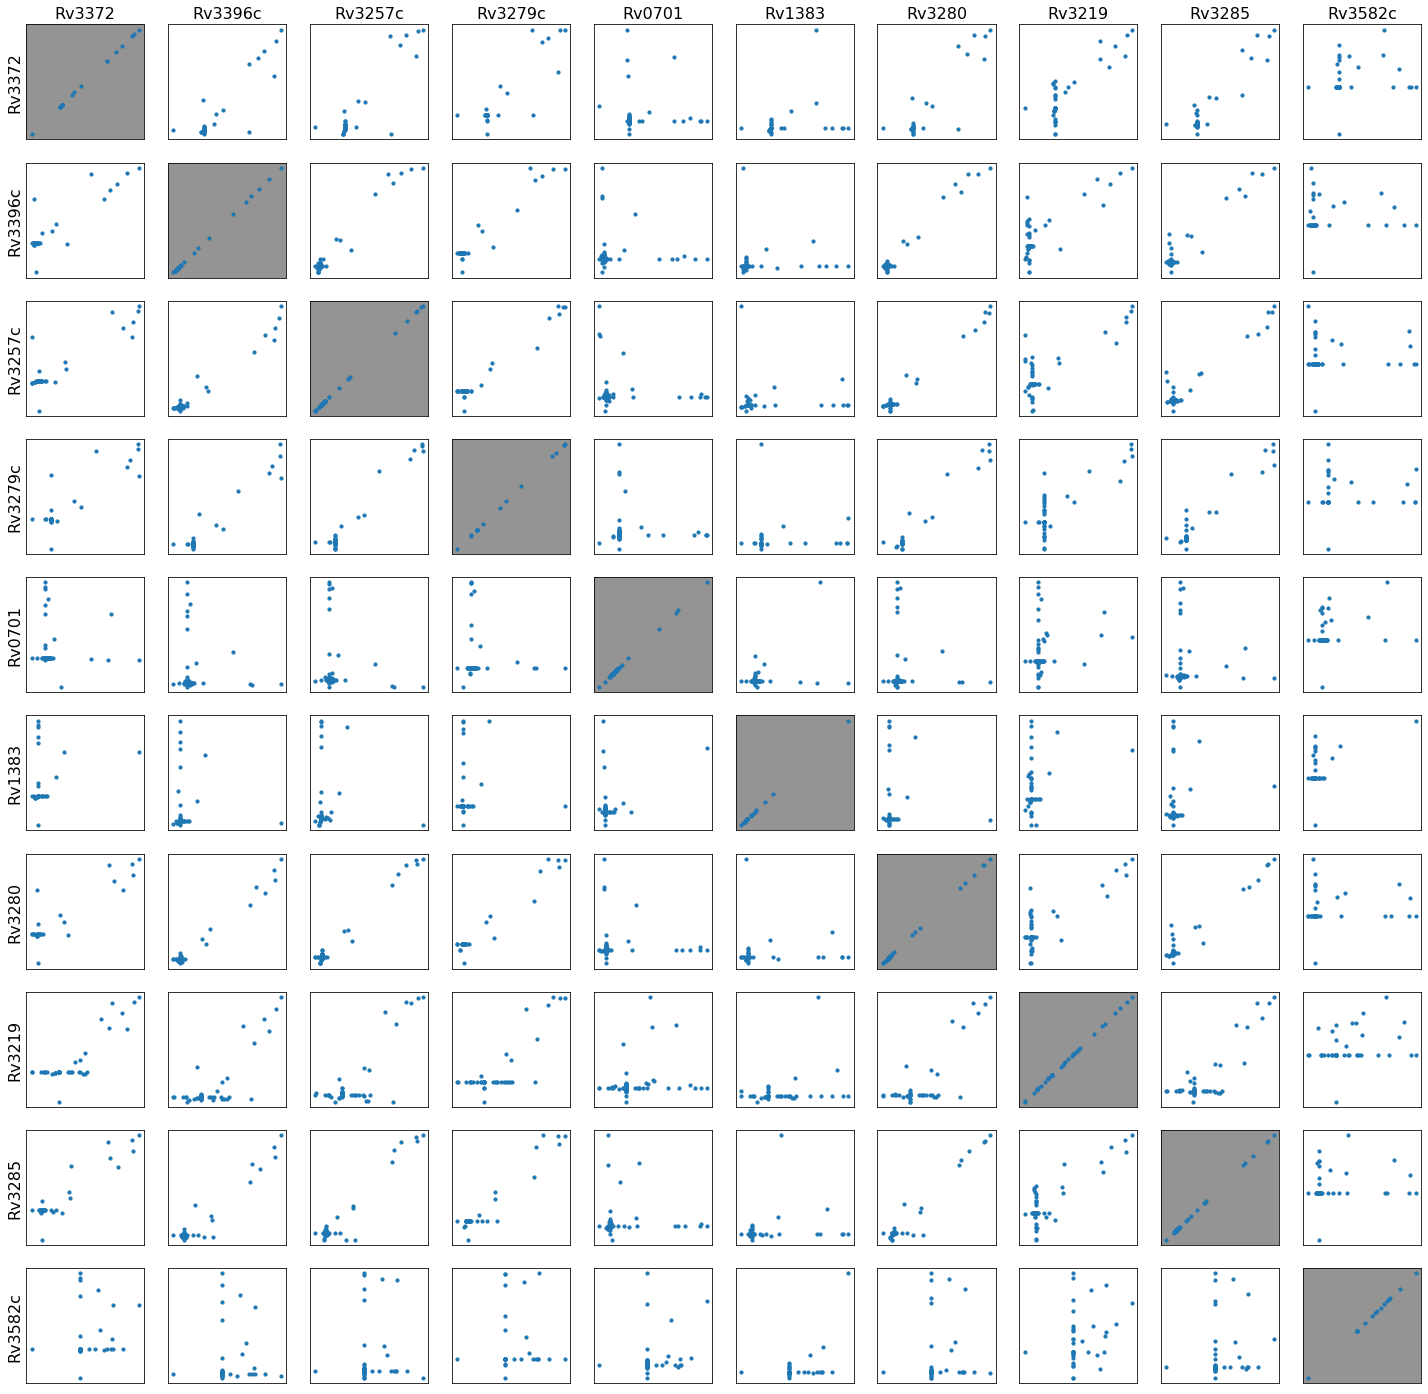

In [51]:
num_rvids = 10
rvid = 'Rv3219'
list_rvid = df_interact[df_interact.lead_gene == rvid].partner_gene.tolist()
list_rvid+=[rvid]
if len(list_rvid)>=num_rvids:
    list_rvid_sample = random.sample(list_rvid, num_rvids)
else:
    list_rvid_sample = list_rvid.copy()

correlation_tile_plot(df_lfc_basis_norm, list_rvid_sample, list_rvid_sample, (25,25), colors_sns)

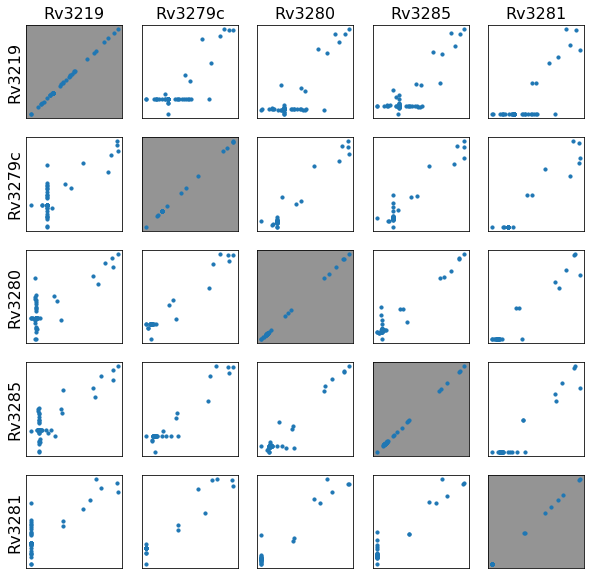

In [52]:
rvid_list = ['Rv3219', 'Rv3279c', 'Rv3280', 'Rv3285', 'Rv3281']
correlation_tile_plot(df_lfc_basis_norm, rvid_list, rvid_list, (10,10), colors_sns)

In [7]:
list_rvid_all = df_interact.lead_gene.unique().tolist()
list_rvid_filt = [rvid for rvid in list_rvid_all if int(rvid.split('Rv')[1][:4]) >= 3135]

In [8]:
num_rvids = 20
for rvid in list_rvid_filt:
    
    list_rvid = df_interact[df_interact.lead_gene == rvid].partner_gene.tolist()
    list_rvid+=[rvid]
    if len(list_rvid)>=num_rvids:
        list_rvid_sample = random.sample(list_rvid, num_rvids)
    else:
        list_rvid_sample = list_rvid.copy()
        
    correlation_tile_plot(df_lfc_basis_norm, list_rvid_sample, list_rvid_sample, (25,25), colors_sns)
    path = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/figs/GLS_TnSeq/'
    fn_fig = rvid+'_interactions.png'
    plt.savefig(os.path.join(path, fn_fig), dpi = 250)
    plt.close()

In [379]:
# rvid = 'Rv2105' #check out the awesome correlations for this insertion seq. 
# GO = 'PE/PPE'
# rvid = 'Rv2681'
# rvid = 'Rv3508' # This PE/PPE gene has amazing correlations! What's crazy is that it comes from correlations with a bunch of insertion elements (WTF) 
#### ==> the high AU/ROC score for PE/PPE and insertion sequences comes from the same underlying biology (!!!!!)
# rvid = 'Rv3590c' # other PE/PPE genes correlate nicely with just one or two other PE/PPE genes (see also Rv2490c)

GO = 'lipid metabolism'
list_rvid_GO = df_lfc[df_lfc['Functional_Category']==GO].Rv_ID.tolist()
list_rvid_GO[:10]

['Rv0033',
 'Rv0035',
 'Rv0045c',
 'Rv0088',
 'Rv0098',
 'Rv0099',
 'Rv0101',
 'Rv0119',
 'Rv0129c',
 'Rv0131c']

Rv0533c
3


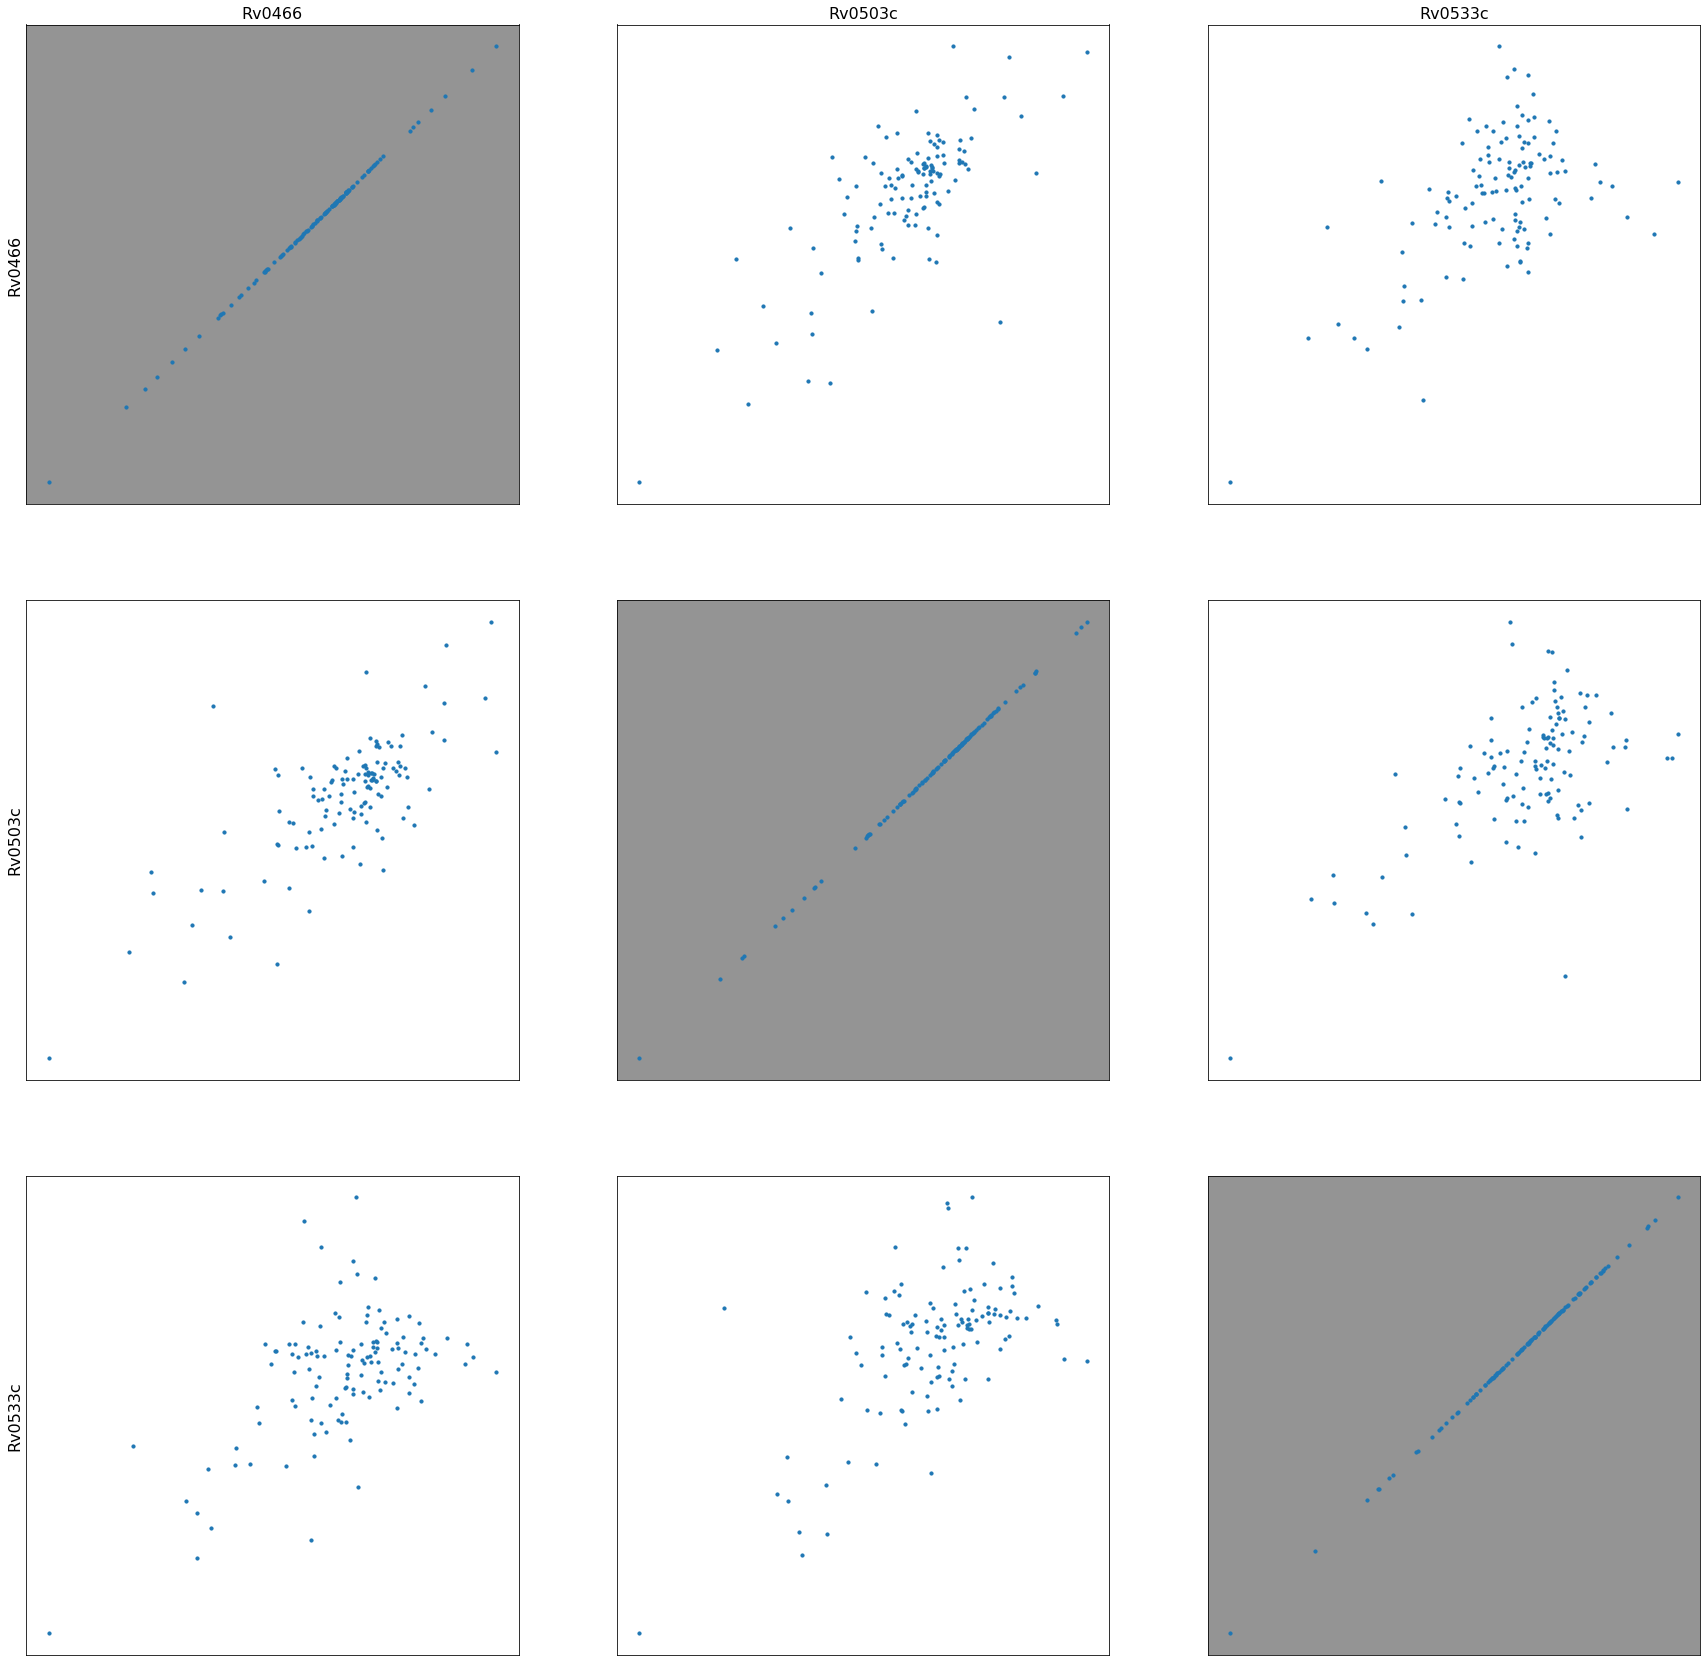

In [400]:
num_rvids = 20
rvid = random.sample(list_rvid_GO,1)[0] #randomly sample from PE/PPE genes: 
# rvid = 'Rv2534c'
print(rvid)

list_rvid = df_interact[df_interact.lead_gene == rvid].partner_gene.tolist()
list_rvid+=[rvid]
if len(list_rvid)>=num_rvids:
    list_rvid_sample = random.sample(list_rvid, num_rvids)
else:
    list_rvid_sample = list_rvid.copy()

    print(len(list_rvid_sample))

correlation_tile_plot(df_lfc_basis_norm, list_rvid_sample, list_rvid_sample, (30,30), cols, list_subset)

## By functional categories: 

In [21]:
fn = 'lfc_mb_filt_BASIS.csv' ## data set only Claire's mutant vs. wildtype screens
path = '../data/standardized_data/cleaned_ML/'
df_lfc = pd.read_csv(os.path.join(path, fn))
df_lfc.shape

(2937, 127)

In [22]:
df_lfc['Functional_Category'].value_counts()

intermediary metabolism and respiration    933
cell wall and cell processes               771
lipid metabolism                           270
information pathways                       242
virulence, detoxification, adaptation      220
regulatory proteins                        197
PE/PPE                                     162
insertion seqs and phages                  142
Name: Functional_Category, dtype: int64

In [24]:
GO = 'PE/PPE'
# GO = 'information pathways'
num_rvids = 20
list_rvid = df_lfc[df_lfc['Functional_Category']==GO].Rv_ID.tolist()
list_rvid_sample = random.sample(list_rvid, num_rvids)
correlation_tile_plot(df_lfc_basis_norm, list_rvid_sample, list_rvid_sample, (30,30), colors_sns, list_subset)

NameError: name 'list_subset' is not defined

## pair-wise scatter plots for genes in the same UMAP clusters: 

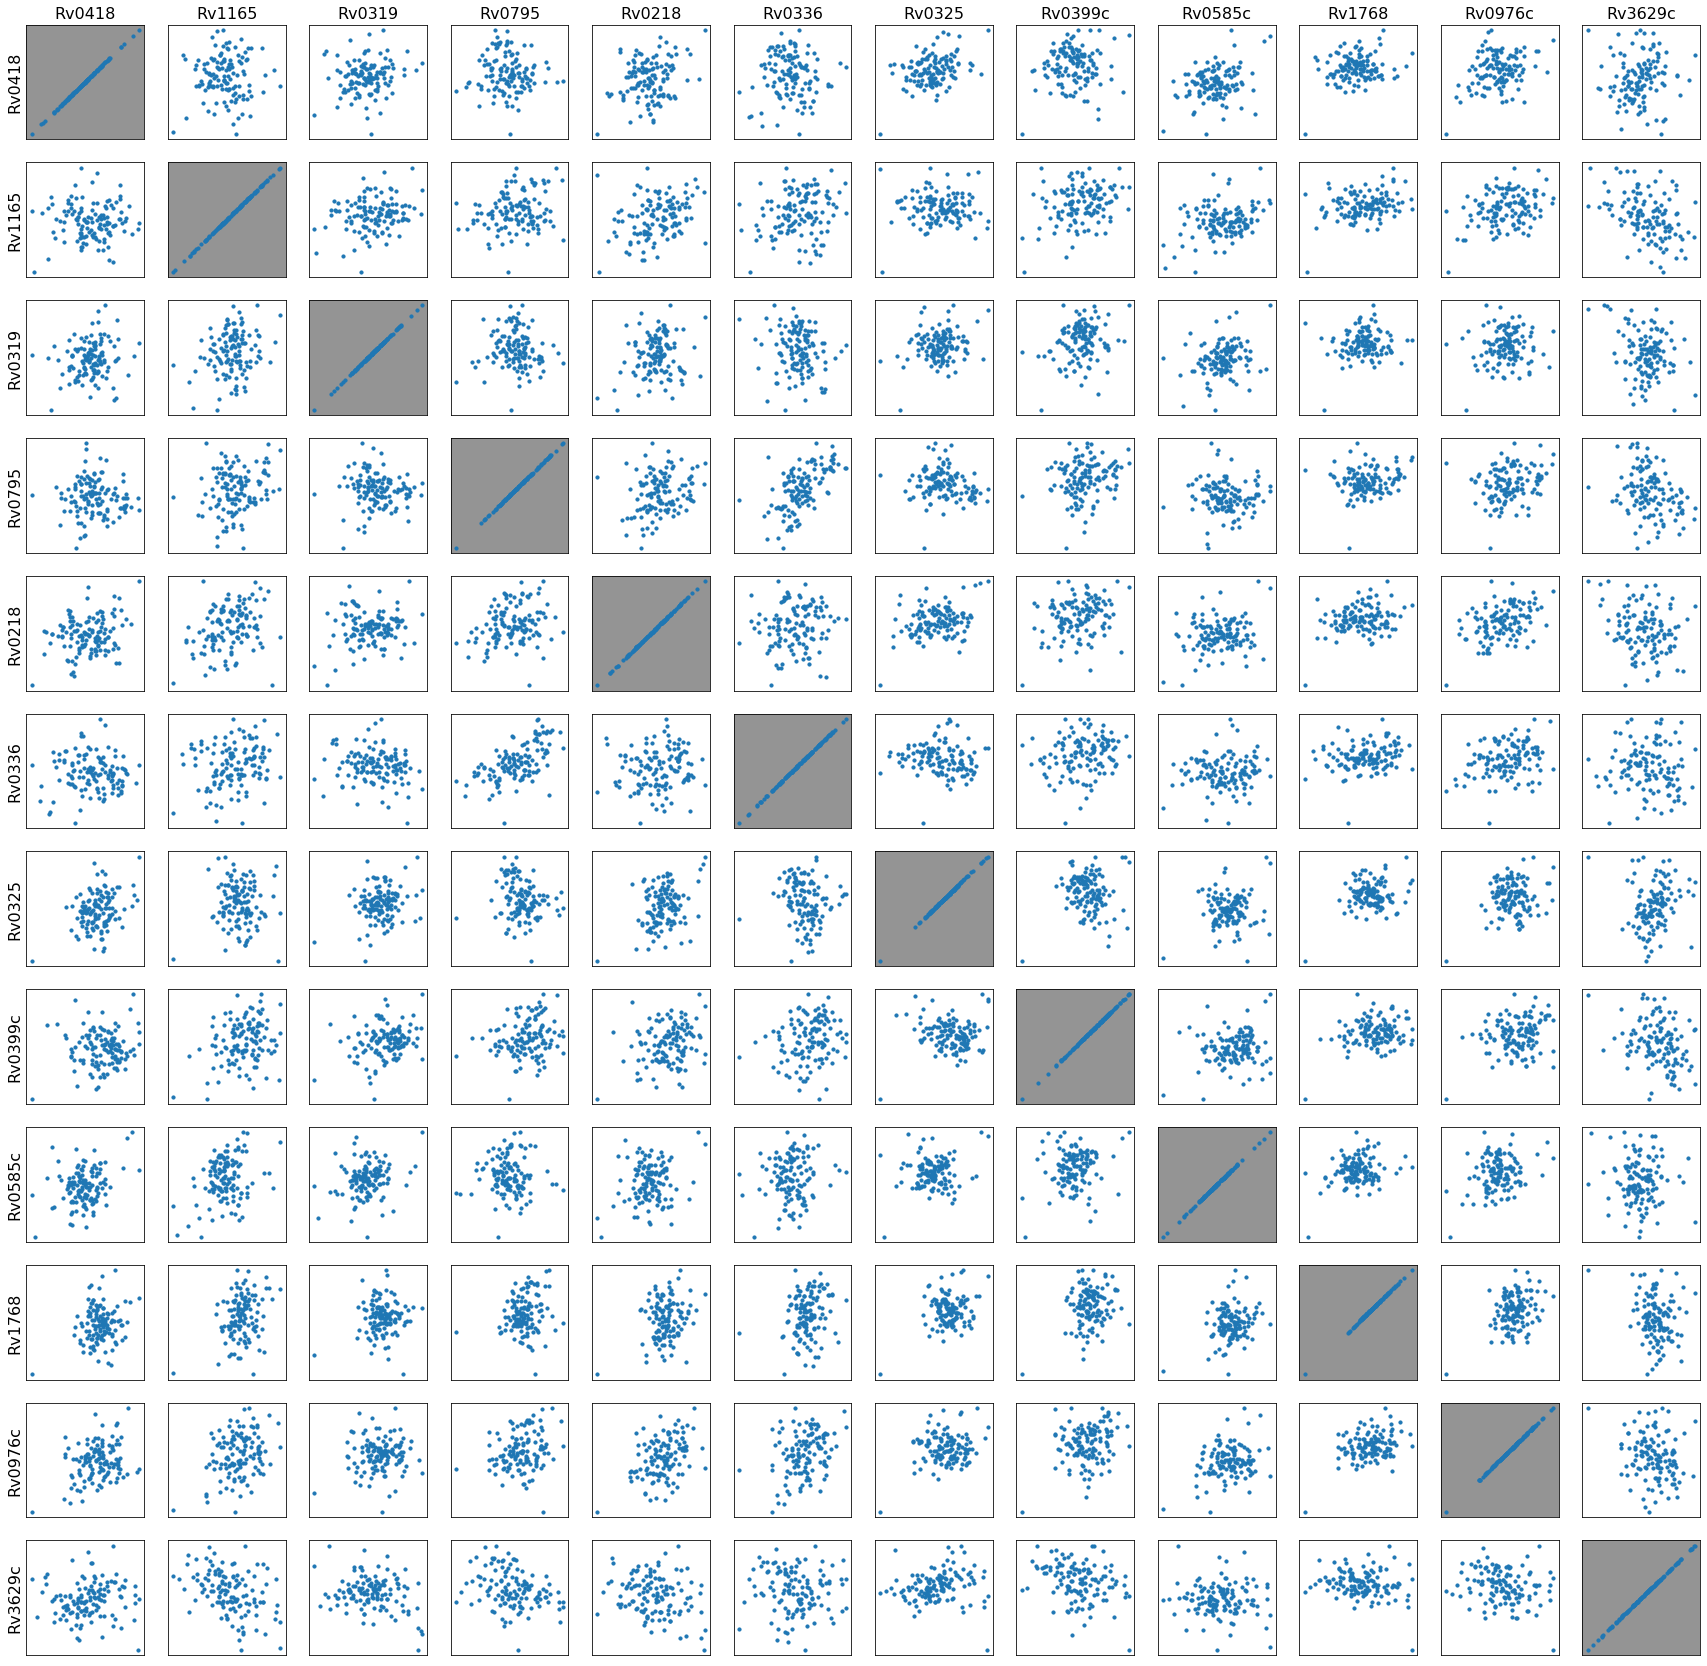

In [235]:
clus_num = 27
fn = '../data/tests/cluster_'+str(clus_num)+'.xlsx'
df_clus = pd.read_excel(fn)
list_rvid = df_clus.Rv_ID.tolist()
correlation_tile_plot(df_lfc_basis_norm, list_rvid, list_rvid, (30,30), cols, list_subset)

## Organizing scatter plots into subfolders: 

In [42]:
import shutil

In [44]:
path_figs = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/figs/GLS_TnSeq_promising/'

Move insertion seqs. genes: 

In [40]:
list_fig_files = os.listdir(path_figs)

In [36]:
str_GO = 'insertion seq'
list_GO = df_lfc[df_lfc['Functional_Category'].str.contains(str_GO)].Rv_ID.tolist()

In [41]:
list_fn_GO = [fn for fn in list_fig_files if fn.split('_')[0] in list_GO]

In [43]:
path_dest = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/figs/GLS_TnSeq_promising/insertion_seqs/'
for fn in list_fn_GO:
    fn_full_src = os.path.join(path_figs, fn)
    fn_full_dest = os.path.join(path_dest, fn)
    shutil.move(fn_full_src, fn_full_dest)

Move PE/PPE genes: 

In [45]:
list_fig_files = os.listdir(path_figs)

In [50]:
str_GO = 'PE/PPE'
list_GO = df_lfc[df_lfc['Functional_Category'].str.contains(str_GO)].Rv_ID.tolist()
list_fn_GO = [fn for fn in list_fig_files if fn.split('_')[0] in list_GO]

In [51]:
path_dest = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/figs/GLS_TnSeq_promising/PE_PPE/'
for fn in list_fn_GO:
    fn_full_src = os.path.join(path_figs, fn)
    fn_full_dest = os.path.join(path_dest, fn)
    shutil.move(fn_full_src, fn_full_dest)

Move figures for only interaction between one pair of genes: 

In [52]:
list_fig_files = os.listdir(path_figs)

In [62]:
list_fig_files_pairs = []
for fig_file in list_fig_files:
    rvid = fig_file.split('_')[0]
    num_interact = df_interact[df_interact.lead_gene==rvid].shape[0]
    if num_interact == 1:
        list_fig_files_pairs.append(fig_file)

In [64]:
path_dest = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/figs/GLS_TnSeq_promising/gene_pairs/'
for fn in list_fig_files_pairs:
    fn_full_src = os.path.join(path_figs, fn)
    fn_full_dest = os.path.join(path_dest, fn)
    shutil.move(fn_full_src, fn_full_dest)

## Testing tiny dataframes:

In [72]:
path = '/home/ajinich/Dropbox/KyuRhee/unknown_function/unknown_redox/figs/GLS_TnSeq_promising/'

In [78]:
list_rvid_lead = [f.split('_')[0] for f in os.listdir(path) if 'Rv' in f and 'png' in f]

In [79]:
for rvid in list_rvid_lead:
    list_rvid_interact = df_interact[df_interact.lead_gene==rvid].partner_gene.tolist()+[rvid]
    df_rvid_func = df_up_func[df_up_func.Rv_ID.isin(list_rvid_interact)].sort_values(by = 'Annotation', ascending = False).copy()
    fn = os.path.join(path, rvid+'_interactions.xlsx')
    df_rvid_func.to_excel(fn, index = False)